This notebook contains the derivation and implementantion of the parametric heating rate. It builds up on several other notebooks that have the individual derivations of energy of photoelectrons as a function of the strength of the radiation field, G, charge, Z, and size, a.

In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


# Parameters for Silicate grains only !!

We describe the energy per photoelectron by

$$ \Gamma_{\mathrm{pe}}^{''}(a, G, Z) = 2.3 \times 10^{-20} \left( \frac{a}{5 \mathrm{\AA}} \right)^{2.39} \left( \frac{G}{1.7} \right) \mathrm{exp}(-\zeta Z)$$

where the parameter $\zeta(a)$ is size dependent, and is given by:

$$ \zeta(a) = 2.953042 \, \left(\frac{a}{5 \mathrm{\AA}}\right)^{-1.03848}$$

In [2]:
def get_Gamma_dotdot_par(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    if grain_type == "silicate":
        Gamma0 = 2.3e-20
        alpha  = 2.39
        zeta   = 2.953042 * (asize / 5.0)**(-1.03848) 
    else:
        print("Not supporting carbonaceous grains yet.")
    
    gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe

Now, I should call parametric fz, and full fz.

Compare parametric fz* parametric Gamma_pe with full fz * full Gamma_pe.

I should then continue to make the function to integrate over the dust grain population

---

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

from scipy.optimize import curve_fit

import time

%matplotlib inline


grain_type = "silicate"
#grain_type = "carbonaceous"
pcent      = 1

########################################################################################

grain_size = 10

save_dir = "/home/jcibanezm/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 
#filename = "CompletenessCopy_0005AA_sil_CR.pkl"

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist = pickle.load(pkl_file)
pkl_file.close

# Load Qabs.
Qabs = fz.get_QabsTable(grain_type, grain_size)

In [28]:
NH2all = np.zeros_like(cdist["zmean"])
G_CR   = np.zeros_like(cdist["zmean"])
for ii in range(len(cdist["zmean"])):
    NH2all[ii] = fz.get_NH2(cdist["fH2shield"][ii], cdist["temp"][ii])
    G_CR[ii]   = fz.get_G_CR(NH2all[ii])

In [ ]:
def Cooling_perGrain()

In [18]:
Gamma_a_par_fz_par   = np.zeros_like(cdist["zmean"])
Gamma_a_par_fz_full  = np.zeros_like(cdist["zmean"])
Gamma_a_full_fz_par  = np.zeros_like(cdist["zmean"])
Gamma_a_full_fz_full = np.zeros_like(cdist["zmean"])

zmean   = np.zeros_like(cdist["zmean"])
cum = 0


Zmin_sil, Zmax_sil = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
ZZ_sil = np.arange(Zmin_sil, Zmax_sil+1)

Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil)

# Compute the energy per photoelectron for a given size and incident radiation field as a function of charge. 
for i in range(Znum_sil):
    Gamma_dotdot_Z_sil[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_sil[i], grain_type, 0.0, Qabs, G0=1.7)


GG    = cdist["G"]
Gtot  = GG + G_CR
Ndust = cdist["Av"]*1.87e21
    
#for index in range(100):
for index in range(len(cdist["zmean"])):
    
    zmin = cdist["zminmax"][index*2]
    zmax = cdist["zminmax"][index*2+1]
    znum = int(zmax - zmin + 1)

    ZZfz = np.arange(zmin, zmax+1, 1)

    ffz = cdist["fdist"][cum:cum+znum]
    cum += znum
    
    zi_down = np.where(ZZ_sil == ZZfz[0])[0][0]# find the index of the ZZ_fz[0] in ZZall 
    zi_up   = np.where(ZZ_sil == ZZfz[-1])[0][0]# find the index of the ZZ_fz[-1] in ZZall
    
    #print("Zi_down", zi_down, "zi_up", zi_up)
    #print(ZZ_sil[zi_down], ZZ_sil[zi_up])
    #print(len(Gamma_dotdot_Z_sil[zi_down:zi_up+1]))
    
    # Scale the energy of photoelectrons with the local strength of the radiation field.
    Gamma_a_Z = Gamma_dotdot_Z_sil * (Gtot[index] / 1.7)
    Gamma_a_full_fz_full[index] = np.sum(ffz*Gamma_a_Z[zi_down:zi_up+1])
    
    #Gamma_a_full_fz_full[index]= np.sum(ffz * Gamma_dotdot_a_Z) 

    
    # Now do the parametric calculation. Again
    ZZpar, ffzpar = fzpar.get_fz(ntot=cdist["nH"][index], T=cdist["temp"][index], xe=cdist["xe"][index], Ntot=Ndust[index],
                                 NH2=NH2all[index], grain_type=grain_type, grain_size=grain_size, xH2=cdist["xH2"][index],
                                 G0=1.7, correct_edens=True)
    
    Gamma_a_Z_par = get_Gamma_dotdot_par(grain_size, Gtot[index], ZZpar, grain_type)
    
    Gamma_a_par_fz_par[index] = np.sum(ffzpar*Gamma_a_Z_par)

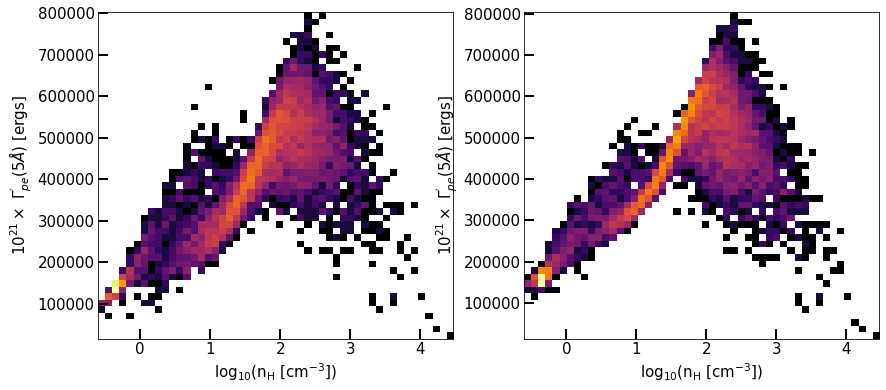

In [26]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)

#ax.hist2d(np.log10(cdist["nH"]),Gamma_a_full_fz_full*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[0, 150]])
ax.hist2d(np.log10(cdist["nH"]),Gamma_a_full_fz_full*1.0e21, bins=50, norm=LogNorm(), cmap="inferno")
#
ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$ [cm$^{-3}$])", fontsize=15)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{pe}(5 \\AA)$ [ergs]", fontsize=15)

#ax.set_yscale("log")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")



ax = fig.add_subplot(122)
#ax.hist2d(np.log10(cdist["nH"]),Gamma_a_par_fz_par*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[0, 150]])
ax.hist2d(np.log10(cdist["nH"]),Gamma_a_par_fz_par*1.0e21, bins=50, norm=LogNorm(), cmap="inferno")
#
ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$ [cm$^{-3}$])", fontsize=15)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{pe}(5 \\AA)$ [ergs]", fontsize=15)

#ax.set_yscale("log")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

fig.show()

#fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/Appendix/HeatingPerGrain_fullvspar_%iAA.pdf"%grain_size, format="pdf")

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/matplotlib/colors.py:932: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/matplotlib/colors.py:933: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


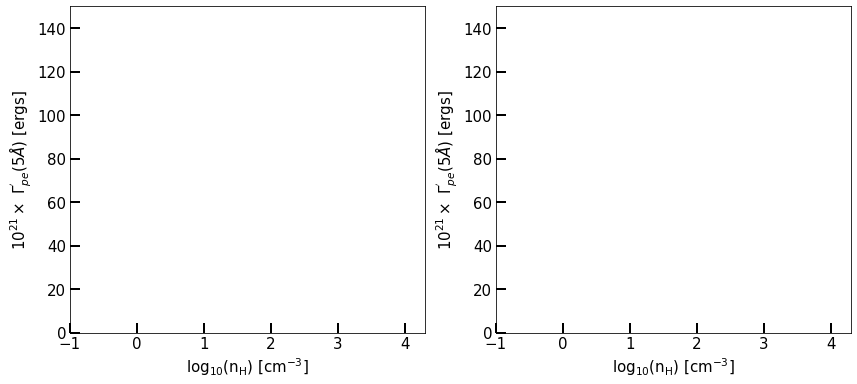

In [19]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)

ax.hist2d(np.log10(cdist["nH"]),Gamma_a_full_fz_full*1.0e21, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[0, 150]])
#
ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$) [cm$^{-3}$]", fontsize=15)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{pe}(5 \\AA)$ [ergs]", fontsize=15)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")


ax = fig.add_subplot(122)
ax.hist2d(np.log10(cdist["nH"]),Gamma_a_par_fz_par*1.0e21/1.5, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 4.3],[0, 150]])
#
ax.set_xlabel("log$_{10}$(n$_{\mathrm{H}}$) [cm$^{-3}$]", fontsize=15)
ax.set_ylabel("10$^{21} \\times$ $\Gamma^{'}_{pe}(5 \\AA)$ [ergs]", fontsize=15)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

fig.show()

#fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/Appendix/HeatingPerGrain_fullvspar_%iAA_scaled.pdf"%grain_size, format="pdf")